# Optimizing the Stretched Period Echelle using Peakbagged Modes
## This is Step 2 in our method of characterizing the mixed modes of low-luminosity giants.

### Loading dependencies...

In [1]:
import os, sys, utils, matplotlib, corner
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy.stats as stats
import time as timer
import sloscillations.frequencies

from scipy.stats import qmc
from sklearn.neighbors import KDTree
from TuRBO.turbo import Turbo1, TurboM
from TuRBO.turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from scipy.spatial.distance import cdist
from sloscillations import mixed_modes_utils, frequencies
from tqdm import tqdm_notebook as tqdm

### Loading in helper functions needed to process the spectrum.

In [2]:
#' It is assumed that DeltaNu is in μHz
def DeltaPi1_from_DeltaNu_RGB(DeltaNu):
    # Compute Period spacing (in s) from deltanu
    return 60 + 1.7*DeltaNu

def Lor_model(pds, peak):
    return peak.height / (1 + ((pds.frequency.values - peak.frequency)/peak.linewidth)**2)

def sinc2_model(pds, peak):
    deltanu = np.mean(np.diff(pds.frequency.values))
    return peak.height * np.sinc((pds.frequency.values - peak.frequency)/deltanu)**2

def fit_model(pds, peaks):

    model = np.ones_like(pds.frequency.values)

    for i in range(len(peaks)):
        if np.isfinite(peaks.linewidth.iloc[i]):
            model += Lor_model(pds, peaks.iloc[i,])
        else:
            model += sinc2_model(pds, peaks.iloc[i, ])
    return model

def prepare_l1_peaks(peaks: pd.DataFrame, summary: pd.DataFrame,
                     AIC_cut: [float] = 0.0, height_cut: [float] = 0.0) -> pd.DataFrame:
    """
    Extract the mixed modes from the peaks dataframe.
    
    Parameters
    ----------
    peaks: pd.DataFrame
        Dataframe containing the detected peaks and parameters.
        
    summary: pd.DataFrame
        Dataframe containing the global stellar information.
    
    AIC_cut: Optional[float] = 0.0
        Cut to make in the Akaike Information Criterion if desired.
        
    height_cut: Optional[float] = 0.0
        Cut to make in the mode height if desired.
        
    Outputs
    -------
    pd.DataFrame
        Dataframe containing the mixed mode peaks and associated mode parameters.
    """
    peaks['x'] = ((peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    # Don't want to include any modes near l=0 or 2s, this is why this and the step in the next cell is performed.
    x_range = [(np.minimum(np.min(peaks.loc[peaks['l'] == 0, 'x']), np.min(peaks.loc[peaks['l'] == 2, 'x'])) - 0.05) % 1,
               (np.maximum(np.max(peaks.loc[peaks['l'] == 0, 'x']), np.max(peaks.loc[peaks['l'] == 2, 'x'])) + 0.05) % 1]
    
    l1_peaks = peaks.loc[(peaks.l == 1) | ~np.isfinite(peaks.l) | (peaks.l == 3)]
    l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    if x_range[0] < x_range[1]:
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] < x_range[1]) | (l1_peaks['x'] > x_range[0]), ] # changed to OR for HeB
    else:
        print(x_range)
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] > x_range[1]) & (l1_peaks['x'] < x_range[0]), ]


    l1_peaks = l1_peaks.loc[(l1_peaks['height'] > height_cut), ]
    l1_peaks = l1_peaks.loc[(l1_peaks['AIC'] > AIC_cut), ]

    return l1_peaks

### Loading in data. Feel free to modify the KICID variable to any other star included in this repository.

In [3]:
kicx = 3973247

data_folder = os.getcwd() + '/peakbag/intermediate/00%d/' %kicx

summary = pd.read_csv(data_folder + 'summary.csv')
pds = pd.read_csv(data_folder + 'pds_bgr.csv')
peaks = pd.read_csv(data_folder + 'peaksMLE.csv')

# Only keep pds around oscillations
pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]

# Read in and filter peaks file to be within +/-3 sigmaEnv of numax
peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]
prepped_l1_peaks = prepare_l1_peaks(peaks, summary=summary, AIC_cut=10)

# Optional: weighting the importance of each peak by their relative amplitude. 
# Here we try to weight the low-amplitude mixed modes more.
prepped_l1_peaks['weights'] = (prepped_l1_peaks['amplitude']/np.sum(prepped_l1_peaks['amplitude']))*1000.

[0.9861900778160002, 0.029366167958541745]


<ipython-input-2-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


### As in Step 1, we pass the peakbagged frequencies to the Frequencies class.

In [4]:
l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) ]
pds_l023_removed = pds.assign(power = pds.power / fit_model(pds, l023_peaks))

freqs = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

### In this step, we are using the dipole ($l=1$) modes and trying to search for a combination of ($\Delta\Pi, q, \epsilon_g, \delta\nu_{\mathrm{rot}}$) that fits the mixed-mode pattern. 

### We will once again use TuRBO, but we will adopt the TuRBO-m algorithm that is more efficient in searching in higher-dimensional spaces.

We have two separate objective functions depending or not we anticipate the presence of core rotational splitting. 
* `freq_tau_rot`: You can specify whether you choose to fit two ($m=-1, 1$) or three ($m=-1,0,1$) rotational components. If not known a priori, fitting for three is the recommended option to find a good fit.
* `freq_tau_rot_singlet`: If you do not anticipate the presence of rotational splitting, use this function to fit only for $m=0$

In [5]:
class freq_tau_rot:
    def __init__(self, inp_freqs, init_dpi, rot_lb=0.1, rot_ub=1.0, eps_g_lb = -0.5, eps_g_ub = 0.5,  nb_comp = 3,
                weights=None):
        self.lb = np.array([init_dpi*0.98, 0.05, eps_g_lb, rot_lb])
        self.ub = np.array([init_dpi*1.02, 0.4, eps_g_ub, rot_ub]) 
        self.inp_freqs = inp_freqs
        self.nb_comp = nb_comp
        self.weights = weights
        
    def __call__(self, x):
        assert len(x) == 4
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        dpi1, coupling, eps_g, split = x[0], x[1], x[2], x[3]
           
        params = {'calc_l0': True, # copy of params with DPi1 set to candidate dpi from loop
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False,
            'DPi1': dpi1,
            'coupling': coupling, 
            'eps_g': eps_g, 
            'split_core': split,
            'split_env': 0.0,
            'l': 1,
            }
    
        freqs(params)

        freqs.generate_tau_values()

        # Compute tau from the zeta value just computed
        real_tau = mixed_modes_utils.peaks_stretched_period(self.inp_freqs, 
                                                                 freqs.frequency, 
                                                                 freqs.tau)

        freqs_p1 = freqs.l1_mixed_freqs + freqs.l1_zeta * split
        freqs_n1 = freqs.l1_mixed_freqs - freqs.l1_zeta * split

        tau_p1 = mixed_modes_utils.peaks_stretched_period(
            freqs_p1, freqs.frequency, freqs.tau)
        tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs.frequency, freqs.tau)

        model_freqs = np.c_[freqs.l1_mixed_freqs, freqs_p1, freqs_n1]
        model_tau = np.c_[freqs.l1_mixed_tau, tau_p1, tau_n1]   


        if self.nb_comp == 2:
            X = np.c_[np.r_[model_tau[:,1] - freqs.shift * freqs.DPi1, 
                            model_tau[:,2] - freqs.shift * freqs.DPi1], 
                      np.r_[model_freqs[:,1], 
                            model_freqs[:,2]]]
        else:
            X = np.c_[np.r_[model_tau[:,0],
                            model_tau[:,1] - freqs.shift * freqs.DPi1, 
                            model_tau[:,2] - freqs.shift * freqs.DPi1], 
                      np.r_[model_freqs[:,0],
                            model_freqs[:,1], 
                            model_freqs[:,2]]]


        y_real = (real_tau - freqs.DPi1*(freqs.shift))
        X_real = np.c_[y_real, self.inp_freqs]
        
        # now compute distance between original frequencies with the frequencies under a new model hypothesis

        c1 = np.vstack((X[:,0]/freqs.DPi1, (X[:,1]-freqs.numax)/freqs.delta_nu)).T
        c2 = np.vstack((X_real[:,0]/freqs.DPi1, (X_real[:,1]-freqs.numax)/freqs.delta_nu)).T
        tree = KDTree(c1, metric='euclidean')
        nearest_dists, nearest_idx = tree.query(c2, k=1)
        
        if self.weights is not None:
            return np.median(nearest_dists*self.weights)
        else:
            return np.median(nearest_dists)

        
        

class freq_tau_rot_singlet:
    def __init__(self, inp_freqs, init_dpi, eps_g_lb = -0.5, eps_g_ub = 0.3, weights = None):
        self.lb = np.array([init_dpi*0.98, 0.05, eps_g_lb])
        self.ub = np.array([init_dpi*1.02, 0.4, eps_g_ub])
        self.inp_freqs = inp_freqs
        self.weights = weights

    def __call__(self, x):
        assert len(x) == 3
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        dpi1, coupling, eps_g = x[0], x[1], x[2]
         
        params = {'calc_l0': True, # copy of params with DPi1 set to candidate dpi from loop
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False,
            'DPi1': dpi1,
            'coupling': coupling, 
            'eps_g': eps_g, 
            'split_core': 0.0,
            'split_env': 0.0,
            'l': 1,
            }
    
        freqs(params)
        freqs.generate_tau_values()

        # Compute tau from the zeta value just computed
        real_tau = mixed_modes_utils.peaks_stretched_period(self.inp_freqs, 
                                                                 freqs.frequency, 
                                                                 freqs.tau)


        model_freqs = freqs.l1_mixed_freqs.reshape(-1,1)
        model_tau = freqs.l1_mixed_tau.reshape(-1,1)

        X = np.c_[model_tau[:,0], model_freqs[:,0]]    
        y_real = (real_tau - freqs.DPi1*(freqs.shift))
        X_real = np.c_[y_real, self.inp_freqs]

        ## KDTree ##
        c1 = np.vstack((X[:,0]/freqs.DPi1, (X[:,1]-freqs.numax)/freqs.delta_nu)).T
        c2 = np.vstack((X_real[:,0]/freqs.DPi1, (X_real[:,1]-freqs.numax)/freqs.delta_nu)).T
        tree = KDTree(c1, metric='euclidean')
        nearest_dists, nearest_idx = tree.query(c2, k=1)
        
        if self.weights is not None:
            return np.median(nearest_dists*self.weights)
        else:
            return np.median(nearest_dists)

### The inputs into the objective function concern the range over which to search:

`inp_freqs`: The dipole mode frequencies that we wish to match to a model of the stretched period echelle diagram.

`init_dpi`: The value of $\Delta\Pi$ over which we will search over. Searching over a more restricted but informed range of $\Delta\Pi$ greatly improves the likelihood of finding a good solution. Ideally, this will be set to the optimal $\Delta\Pi$ from the PSxPS from Part 1. For this demo, we will use the $\Delta\Pi$ inferred from $\Delta\nu$.

`rot_lb`: $\delta\nu_{\mathrm{rot}}$ lower bound. Default: 0.1

`rot_ub`: $\delta\nu_{\mathrm{rot}}$ upper bound. Default: 1.0

`eps_g_lb`: $\epsilon_g$ lower bound. Default: -0.5

`eps_g_ub`: $\epsilon_g$ upper bound. Default: 0.5

`nb_comp`: Only pertinent to `freq_tau_rot`. Number of rotationally split components (2 or 3). Default: 3.

`weights`: Weights for each mixed mode. Default: None (i.e. unweighted). 

In [6]:
f_rot = freq_tau_rot(inp_freqs = prepped_l1_peaks['frequency'].values,# generic case
    init_dpi=DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu)[0],
    rot_lb=0.05, 
    rot_ub=1.0,
    eps_g_lb = -0.05, 
    eps_g_ub =0.35, 
    nb_comp = 3, 
    weights=(prepped_l1_peaks['amplitude'].values/np.sum(prepped_l1_peaks['amplitude'].values))*1000.) 

# f_rot = freq_tau_rot_singlet( # fitting only m=0
#     init_dpi = DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu), 
#     eps_g_lb = -0.5,
#     eps_g_ub =0.35, 
#     weights=(prepped_l1_peaks['amplitude'].values/np.sum(prepped_l1_peaks['amplitude'].values))*1000.) 

### Now proceed with optimization using TuRBO-m. Since the space is now higher-dimensional compared to Step 1, we will now run over 5000 iterations.

In [7]:
# Turbo M
turbo1_rot = TurboM(
    f=f_rot,  # Handle to objective function
    lb=f_rot.lb,  # Numpy array specifying lower bounds
    ub=f_rot.ub,  # Numpy array specifying upper bounds
    n_init=50,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=5000,  # Maximum number of evaluations
    n_trust_regions=10,  # Number of trust regions
    batch_size=100,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=64,  # Run on the CPU for small datasets
    device="cuda",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)
# turbo1_rot.failtol = 20 # double the tolerance
turbo1_rot.n_cand = 5000

Using dtype = torch.float64 
Using device = cuda


In [8]:
init_time = timer.time()
turbo1_rot.optimize()
print('Elapsed Time: ', timer.time()-init_time)

TR-0 starting from: 0.8446
TR-1 starting from: 0.6352
TR-2 starting from: 0.8071
TR-3 starting from: 0.7289
TR-4 starting from: 0.8537
TR-5 starting from: 0.6643
TR-6 starting from: 0.5717
TR-7 starting from: 0.9686
TR-8 starting from: 0.7411
TR-9 starting from: 0.8122
1000) New best @ TR-1: 0.5185, Best Sol: [81.28569284  0.13489403  0.19497896  0.19765864]
1000) New best @ TR-5: 0.4817, Best Sol: [81.15799552  0.18021749  0.21098213  0.46544798]
1100) New best @ TR-5: 0.3132, Best Sol: [81.19496569  0.14379367  0.17866964  0.43780477]
1200) New best @ TR-5: 0.1706, Best Sol: [81.21905195  0.13183225  0.14773655  0.40301432]
1400) New best @ TR-5: 0.1555, Best Sol: [81.22466865  0.13817527  0.14166343  0.39954814]
1500) New best @ TR-5: 0.1463, Best Sol: [81.20293775  0.13487373  0.16567679  0.3953582 ]
1600) New best @ TR-5: 0.1461, Best Sol: [81.19027805  0.13341857  0.17906716  0.39205533]
1800) New best @ TR-5: 0.141, Best Sol: [81.17352127  0.13595721  0.19326043  0.39312199]
200

In [9]:
X_rot = turbo1_rot.X  # Evaluated points
fX_rot = turbo1_rot.fX  # Observed values
ind_best_rot = np.argmin(fX_rot)

f_best_rot, x_best_rot = fX_rot[ind_best_rot], X_rot[ind_best_rot, :]
print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_rot, np.around(x_best_rot, 3)))

Best value found:
	f(x) = 0.137
Observed at:
	x = [81.178  0.136  0.189  0.395]


### `x_best_rot` is the best solution of ($\Delta\Pi, q, \epsilon_g, \delta\nu_{\mathrm{rot}}$) after optimizing for 5000 iterations. Let us visualize a model of the best fit and how our observed points compare.

In [10]:
# Set up a new frequencies class for visualization purposes

freqs_dummy = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)


try: # if we run with rotational splitting, otherwise assume no observed rotational splitting
    splitting=x_best_rot[3]
except:
    splitting = 0
    
params = {'calc_l0': True, 
            'calc_l2': True, 
            'calc_l3': False, 
            'calc_nom_l1': True, 
            'calc_mixed': True, 
            'calc_rot': False, 
            'DPi1': x_best_rot[0],
            'coupling': x_best_rot[1],
            'eps_g': x_best_rot[2],
            'l': 1, 
            }

freqs_dummy(params)
freqs_dummy.generate_tau_values()


### Frequencies and tau for observed (peakbagged) values ###
inp_freqs = prepped_l1_peaks['frequency'].values
real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                         freqs_dummy.frequency, 
                                                         freqs_dummy.tau)
real_tau = real_tau - freqs_dummy.DPi1*(freqs_dummy.shift)


### Frequencies and tau for model (peakbagged) values ###
freqs_p1 = freqs_dummy.l1_mixed_freqs + freqs_dummy.l1_zeta * splitting
freqs_n1 = freqs_dummy.l1_mixed_freqs - freqs_dummy.l1_zeta * splitting

tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs_dummy.frequency, freqs_dummy.tau)
tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs_dummy.frequency, freqs_dummy.tau)

model_freqs = np.c_[freqs_dummy.l1_mixed_freqs, freqs_p1, freqs_n1]
model_ng = np.c_[freqs_dummy.l1_ng, freqs_dummy.l1_ng, freqs_dummy.l1_ng]
model_tau = np.c_[freqs_dummy.l1_mixed_tau, tau_p1, tau_n1]

plot_tau = np.mod(real_tau, freqs_dummy.DPi1)
plot_tau[plot_tau > freqs_dummy.DPi1/2] -= freqs_dummy.DPi1

if not splitting:
    X = np.c_[model_tau[:,0], model_freqs[:,0]]
else:
    X = np.c_[np.r_[model_tau[:,0],
                    model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
                    model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
              np.r_[model_freqs[:,0],
                    model_freqs[:,1], 
                    model_freqs[:,2]]]
    # X = np.c_[np.r_[model_tau[:,1] - freqs_dummy.shift * freqs_dummy.DPi1, 
    #                 model_tau[:,2] - freqs_dummy.shift * freqs_dummy.DPi1], 
    #           np.r_[model_freqs[:,1], 
    #                 model_freqs[:,2]]] # plot only m = +/- 1 components


### After computing synthetic mixed-mode frequencies and $\tau$, we compare this to those computed for the peakbagged values and plot them.

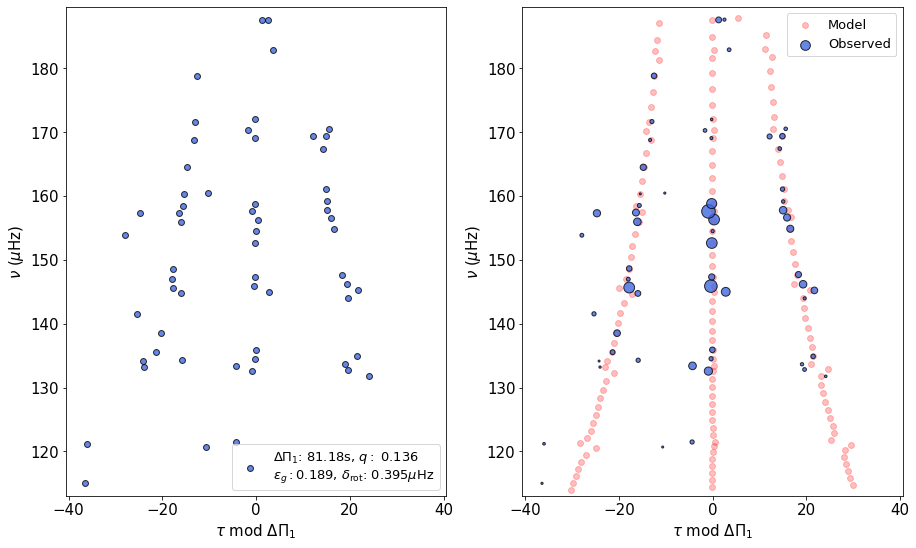

In [11]:
## Presenting in stretched period echelle form ##
plot_model_tau = np.mod(X[:,0], freqs_dummy.DPi1)
plot_model_tau[plot_model_tau > freqs_dummy.DPi1/2] -=  freqs_dummy.DPi1


fig = plt.figure(figsize=(15,9))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
fs = 15

ax1.scatter(plot_tau, inp_freqs, s=35,
            c='royalblue', edgecolor='k', alpha=0.8,
           label='$\\Delta\\Pi_1$: %.2fs, $q:$ %.3f\n$\\epsilon_g: %.3f$, $\\delta_\\mathrm{rot}$: %.3f$\\mu$Hz'
           %(x_best_rot[0], x_best_rot[1], x_best_rot[2], splitting))
ax1.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
ax1.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
ax1.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$', fontsize=fs)
ax1.set_xlim(-freqs_dummy.DPi1/2, freqs_dummy.DPi1/2)
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend(prop={'size': fs-2})


ax2.scatter(plot_model_tau, X[:,1], s=35, c='r', alpha=0.25, label='Model')
ax2.scatter(plot_tau, inp_freqs, s=np.power(prepped_l1_peaks['height'].values, 1.15), 
            c='royalblue', edgecolor='k', alpha=0.8, label='Observed')
ax2.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
ax2.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
ax2.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$', fontsize=fs)
ax2.set_xlim(-freqs_dummy.DPi1/2, freqs_dummy.DPi1/2)
ax2.legend(prop={'size': fs-2})
ax2.tick_params(axis='both', which='major', labelsize=fs)

plt.show()

### It would be useful to be able to obtain some measure of uncertainty of the the best-fitting solution shown above. To do this, we first examine the parameter space sampled by the BayesOpt algorithm.

<ipython-input-101-3bce772d3525>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0.1)


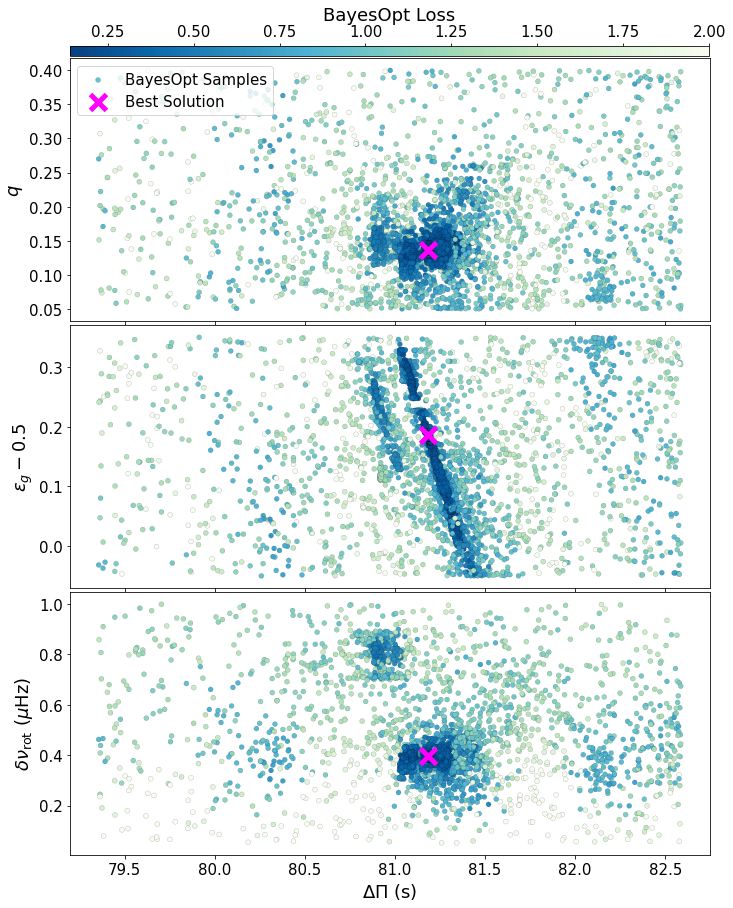

In [101]:
fig = plt.figure(figsize=(10, 12
                         ))

cmap = plt.get_cmap('Accent')

fs=18

ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)

ax1.scatter(X_rot[:,0], X_rot[:,1], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax1.set_ylabel('$q$', fontsize=fs)
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=fs-3)
ax1.scatter(x_best_rot[0], x_best_rot[1], c='magenta', marker='x', s=255, lw=5)

ax2.scatter(X_rot[:,0], X_rot[:,2], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax2.set_ylabel('$\\epsilon_g-0.5$', fontsize=fs)
ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=fs-3)
ax2.scatter(x_best_rot[0], x_best_rot[2], c='magenta', marker='x', s=255, lw=5)

im3 = ax3.scatter(X_rot[:,0], X_rot[:,3], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax3.set_ylabel('$\\delta\\nu_{\\mathrm{rot}}$ ($\\mu$Hz)', fontsize=fs)
ax3.tick_params(axis='both', which='major', labelsize=fs-3)
imbest = ax3.scatter(x_best_rot[0], x_best_rot[3], c='magenta', marker='x', s=255, lw=5)

ax3.set_xlabel('$\\Delta\\Pi$ (s)', fontsize=fs)

cax = fig.add_axes([0.096, 0.99, 0.888, 0.0115])
colormap = plt.cm.GnBu_r 
normalize = matplotlib.colors.Normalize(vmin=min(fX_rot),
                                        vmax=2)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
cb1 = fig.colorbar(sm, cax=cax, orientation='horizontal')
cb1.set_label('BayesOpt Loss', fontsize=fs)
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=fs-3) 

l = ax1.legend([(im3), imbest], 
               ['BayesOpt Samples', 'Best Solution'],
               numpoints=1, prop={'size': fs-3}, loc='upper left')

plt.tight_layout(h_pad=0.1)
plt.show()

### Notice that the samples are rather clumpy, and this is due to the exploration vs exploitation nature of the BayesOpt algorithm. We want to leverage this property of the algorithm to estimate some form of uncertainty bound for our best estimate.

In [98]:
import bochamm.clustering as clustering

### We perform density based clustering using the DBSCAN algorithm as implemented in sci-kit learn. The DBSCAN algorithm relies on a parameter $\epsilon$ that determines the maximum neighbourhood surrounding a point to consider as a cluster.

### We determine the optimal value of $\epsilon$ by calculating the the Euclidean distance of each point to its three nearest neighbours, and then sorting the points in order of increasing nearest neighbour distance to create an 'elbow curve'. This follows the methods described by Rahmah & Sitanggang (2016).

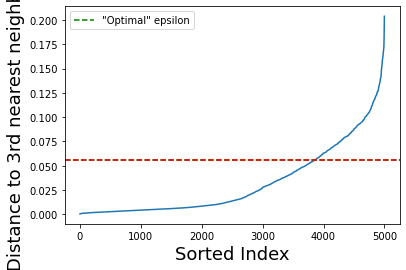

Number of Clusters Found: 2


In [99]:
clust = clustering.Clustering(X_rot, fX_rot)
X_clust, reduced_loss, cluster_labels = clust(eps=None, min_samples=30, n_neighbours=3, verbose=False, plot=True)
n_solns = (np.unique(cluster_labels) >= 0).sum()
print('Number of Clusters Found: %d' %n_solns)

### The optimal value of epsilon is where the elbow curve starts to rise. A neat trick on doing this geometrically can be found at https://datascience.stackexchange.com/questions/57122/in-elbow-curve-how-to-find-the-point-from-where-the-curve-starts-to-rise

### Now we re-visualize where the clusters fall in the resulting parameter space

<ipython-input-105-06e66762ef14>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0.1)


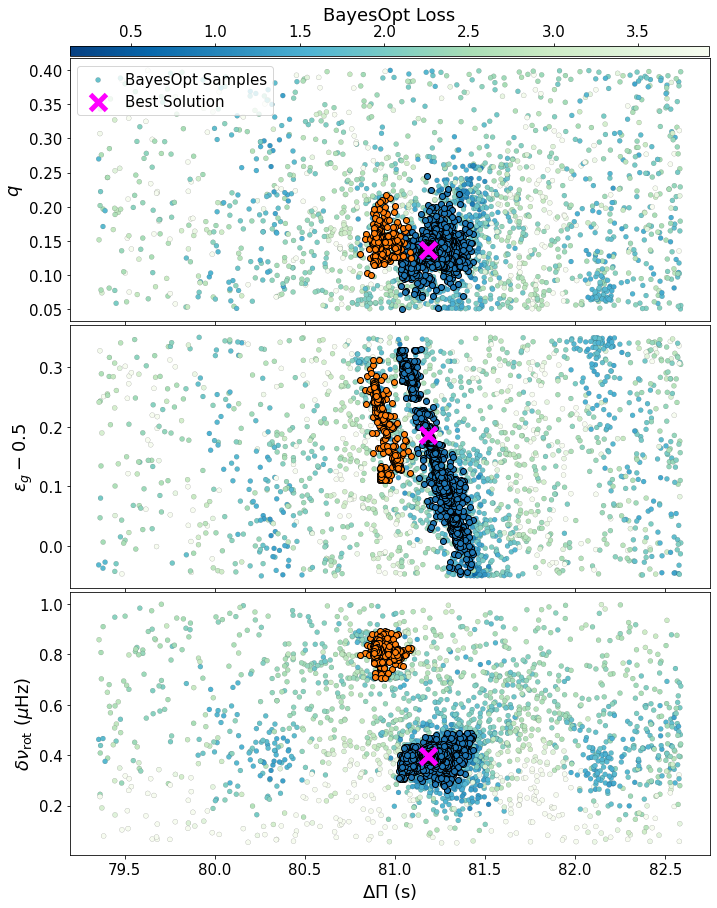

In [105]:
fig = plt.figure(figsize=(10, 12
                         ))

cmap = plt.get_cmap('Accent')

fs=18

ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)

ax1.scatter(X_rot[:,0], X_rot[:,1], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax1.set_ylabel('$q$', fontsize=fs)
ax1.set_xticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=fs-3)
ax1.scatter(x_best_rot[0], x_best_rot[1], c='magenta', marker='x', s=255, lw=5, zorder=3)

ax2.scatter(X_rot[:,0], X_rot[:,2], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax2.set_ylabel('$\\epsilon_g-0.5$', fontsize=fs)
ax2.set_xticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=fs-3)
ax2.scatter(x_best_rot[0], x_best_rot[2], c='magenta', marker='x', s=255, lw=5, zorder=3)

im3 = ax3.scatter(X_rot[:,0], X_rot[:,3], c=fX_rot, vmax=2, cmap='GnBu_r', s=25, edgecolor='k', lw=0.1)
ax3.set_ylabel('$\\delta\\nu_{\\mathrm{rot}}$ ($\\mu$Hz)', fontsize=fs)
ax3.tick_params(axis='both', which='major', labelsize=fs-3)
imbest = ax3.scatter(x_best_rot[0], x_best_rot[3], c='magenta', marker='x', s=255, lw=5, zorder=3)

ax3.set_xlabel('$\\Delta\\Pi$ (s)', fontsize=fs)

cax = fig.add_axes([0.096, 0.99, 0.888, 0.0115])
colormap = plt.cm.GnBu_r 
normalize = matplotlib.colors.Normalize(vmin=min(fX_rot),
                                        vmax=max(fX_rot))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
cb1 = fig.colorbar(sm, cax=cax, orientation='horizontal')
cb1.set_label('BayesOpt Loss', fontsize=fs)
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=fs-3) 

l = ax1.legend([(im3), imbest], 
               ['BayesOpt Samples', 'Best Solution'],
               numpoints=1, prop={'size': fs-3}, loc='upper left')

### Plotting clusters ###

for x in np.unique(cluster_labels):
    ax1.scatter(X_clust[:,0][cluster_labels == x], X_clust[:,1][cluster_labels == x], label=x, edgecolor='k')
    ax2.scatter(X_clust[:,0][cluster_labels == x], X_clust[:,2][cluster_labels == x], label=x, edgecolor='k')
    ax3.scatter(X_clust[:,0][cluster_labels == x], X_clust[:,3][cluster_labels == x], label=x, edgecolor='k')

plt.tight_layout(h_pad=0.1)
plt.show()

### We see that we have detected the presence of two clusters within our sampling. We now identify the cluster containing our best solution and visualize its distribution.

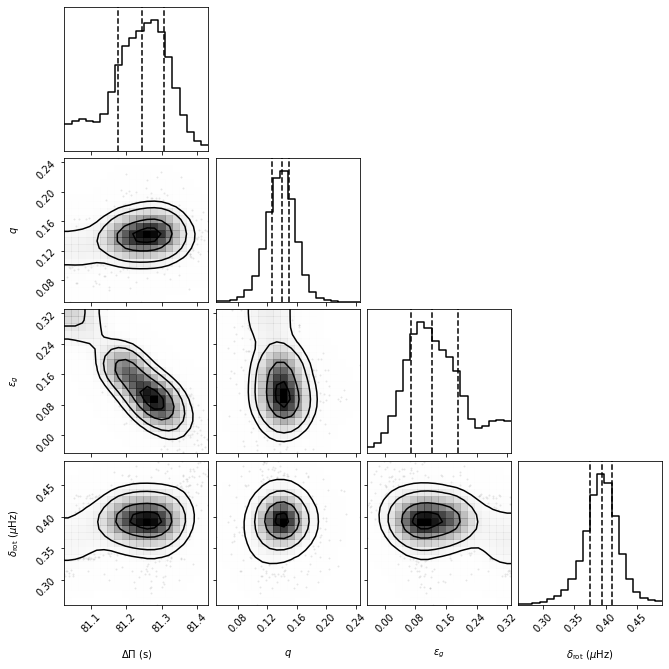

In [112]:
if X_clust.shape[1] == 4: 
    labels=["$\\Delta\\Pi$ (s)", "$q$", "$\\epsilon_g$", "$\\delta_{\\mathrm{rot}}$ ($\\mu$Hz)"]
else: 
    labels=["$\\Delta\\Pi$ (s)", "$q$", "$\\epsilon_g$"]

clust_min_losses = []

for i in range(n_solns): # For each cluster, we calculate the point having the lowest BayesOpt score (lower = better)
    clust_min_losses.append(np.min(reduced_loss[cluster_labels == i]))

best_cluster = np.argmin(clust_min_losses) # Our best solution lies in the cluster with the lowest score
    
figure = corner.corner(X_clust[cluster_labels == np.argmin(clust_min_losses), :], 
                   labels=labels,
                   quantiles=[0.16, 0.5, 0.84], smooth1d=1.5, smooth=2)
plt.show()

### Notice that the distributions for $\Delta\Pi$ and $\epsilon_g$ are typically elongated. This is because these two are known to be degenerate with one another, and so their estimates should have some intrinsic uncertainty. 

### There are numerous ways for which we may define an uncertainty interval from this distribution. In the paper, we use 68% Highest Density Intervals as defined in arviz.

In [117]:
import arviz as az
## Method of using Highest Density Intervals ##
 
intervals = az.hdi(X_clust[cluster_labels == np.argmin(clust_min_losses), :], hdi_prob=.68)
dpi_e, dpi_E = np.abs(x_best_rot[0] - intervals[0][0]),np.abs(x_best_rot[0] - intervals[0][1])
q_e, q_E = np.abs(x_best_rot[1] - intervals[1][0]),np.abs(x_best_rot[1] - intervals[1][1])
eps_g_e, eps_g_E = np.abs(x_best_rot[2] - intervals[2][0]),np.abs(x_best_rot[2] - intervals[2][1])

if X_clust.shape[1] == 4:
    drot_e, drot_E =  np.abs(X_rot[3] - intervals[3][0]),np.abs(X_rot[3] - intervals[3][1])
else:
    drot_e = drot_E = 0   

<ipython-input-117-f05281baf8f7>:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  intervals = az.hdi(X_clust[cluster_labels == np.argmin(clust_min_losses), :], hdi_prob=.68)


In [126]:
for i, ix in enumerate(intervals):
    print('%s interval: (%.3f, %.3f)' %(labels[i], ix[0], ix[1]))

# dpi_e, dpi_E, intervals[0], x_best_rot[0]

$\Delta\Pi$ (s) interval: (81.175, 81.306)
$q$ interval: (0.130, 0.151)
$\epsilon_g$ interval: (0.069, 0.192)
$\delta_{\mathrm{rot}}$ ($\mu$Hz) interval: (0.380, 0.414)


### Let us get a sense of how these uncertainties look like in the stretched period echelle diagram.

### First we sample points within the best cluster.

In [129]:
from tqdm import tqdm_notebook as tqdm

freqs_samp = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

sampz = X_clust[cluster_labels == np.argmin(clust_min_losses), :]

## Generate the freqs and tau associated with the sample, and then plot later

plot_model_tau_samps, plot_model_freq_samps = [], []

for i in tqdm(range(len(sampz)), total=len(sampz)):
    samp = sampz[i]

    try:
        splitting=samp[3]
    except:
        splitting = 0

    params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': True, 
                'calc_rot': False, 
                'DPi1': samp[0],
                'coupling': samp[1],
                'eps_g': samp[2],# x_best_rot[2],
                'l': 1, 
                }

    freqs_samp(params)
    freqs_samp.generate_tau_values()
    
    # Visualize the uncertainties by scattering the model
    
    freqs_p1_samp = freqs_samp.l1_mixed_freqs + freqs_samp.l1_zeta * splitting
    freqs_n1_samp = freqs_samp.l1_mixed_freqs - freqs_samp.l1_zeta * splitting

    tau_p1_samp = mixed_modes_utils.peaks_stretched_period(freqs_p1_samp, freqs_samp.frequency, freqs_samp.tau)
    tau_n1_samp = mixed_modes_utils.peaks_stretched_period(freqs_n1_samp, freqs_samp.frequency, freqs_samp.tau)

    model_freqs_samp = np.c_[freqs_samp.l1_mixed_freqs, freqs_p1_samp, freqs_n1_samp]
    model_tau_samp = np.c_[freqs_samp.l1_mixed_tau, tau_p1_samp, tau_n1_samp]

    # triplet case
    X_samp = np.c_[np.r_[model_tau_samp[:,0],
                    model_tau_samp[:,1] - freqs_samp.shift * freqs_samp.DPi1, 
                    model_tau_samp[:,2] - freqs_samp.shift * freqs_samp.DPi1], 
              np.r_[model_freqs_samp[:,0],
                    model_freqs_samp[:,1], 
                    model_freqs_samp[:,2]]]

    plot_model_tau_samp = np.mod(X_samp[:,0], freqs_samp.DPi1)
    plot_model_tau_samp[plot_model_tau_samp > freqs_samp.DPi1/2] -=  freqs_samp.DPi1
    plot_model_tau_samps.append(plot_model_tau_samp)
    plot_model_freq_samps.append(X_samp[:,1])

<ipython-input-129-06f71ebd766a>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(sampz)), total=len(sampz)):


  0%|          | 0/2665 [00:00<?, ?it/s]

### Now we plot how much the stretched period echelle is perturbed by points within the distribution.  Note that for each iteration, we center the plot at the drawn value of $\epsilon_g$. Therefore we will not see any change in the $m=0$ component. However, we will certainly see how much the $m=\pm1$ components change as we vary $\Delta\Pi$, $q$, and $\delta\nu_{\mathrm{rot}}$.

<ipython-input-140-f8b276744426>:40: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  x1=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.67)[:,0],  sigma=sigz),
<ipython-input-140-f8b276744426>:41: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  x2=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.67)[:,1],  sigma=sigz),
<ipython-input-140-f8b276744426>:46: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  x1=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.95)[:,0],  sigma=sigz),
<ipython-input-140-f8b276744426>:47: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (c

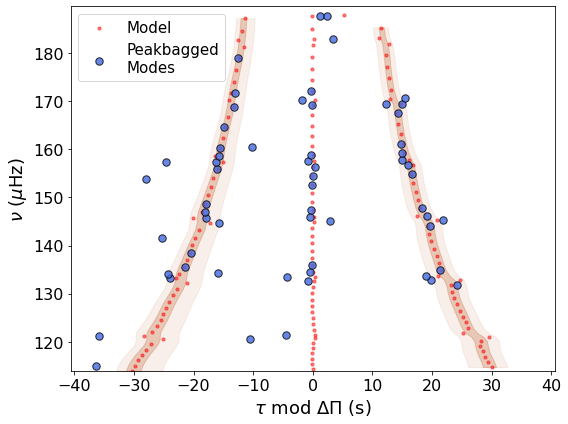

In [140]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d


fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
fs = 18

lentau = []
n1_tau_int, n1_freq_int = [], []
p1_tau_int, p1_freq_int = [], []

for i in range(len(plot_model_freq_samps)): 
    # selecting positive and negative tau in the echelle for interpolation
    # +/- 5 is the tau value at which the m = +/-1 ridges are located 
    
    if i % 1 == 0:
        if len(plot_model_tau_samps[i][ plot_model_tau_samps[i] < -5 ]) == 49: 
            # making sure with have equal number across to get an envelope
            n1_tau_int.append(plot_model_tau_samps[i][ plot_model_tau_samps[i] < -5])
            n1_freq_int.append(plot_model_freq_samps[i][ plot_model_tau_samps[i] < -5])
            
        if len(plot_model_tau_samps[i][ plot_model_tau_samps[i] > 5 ]) == 48:
            p1_tau_int.append(plot_model_tau_samps[i][ plot_model_tau_samps[i] > 5])
            p1_freq_int.append(plot_model_freq_samps[i][ plot_model_tau_samps[i] > 5])
            

    
ax1.scatter(plot_model_tau, X[:,1], s=10, c='r', alpha=0.5, label='Model')
ax1.scatter(plot_tau, inp_freqs, s=55,
            c='royalblue', edgecolor='k', alpha=0.8, label='Peakbagged\nModes')
ax1.set_ylim(np.min(inp_freqs)-1, np.max(inp_freqs)+2)
ax1.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
ax1.set_xlabel('$\\tau$ mod $\\Delta\\Pi$ (s)', fontsize=fs)
ax1.set_xlim(-x_best_rot[0]/2, x_best_rot[0]/2)
ax1.tick_params(axis='both', which='major', labelsize=fs-2)

sigz = 1.25
ax1.fill_betweenx(y= np.median(np.array(n1_freq_int), axis=0), 
                  x1=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.67)[:,0],  sigma=sigz),
                            x2=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.67)[:,1],  sigma=sigz), 
                  alpha=0.3, 
                 color='#C36A3C', zorder=0,
                 )
ax1.fill_betweenx(y= np.median(np.array(n1_freq_int), axis=0), 
                  x1=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.95)[:,0],  sigma=sigz),
                            x2=gaussian_filter1d(az.hdi(np.array(n1_tau_int), hdi_prob = 0.95)[:,1],  sigma=sigz),
                  alpha=0.1, 
                 color='#C36A3C', zorder=0)
ax1.fill_betweenx(y= np.median(np.array(p1_freq_int), axis=0), 
                  x1=gaussian_filter1d(az.hdi(np.array(p1_tau_int), hdi_prob = 0.67)[:,0],  sigma=sigz),
                            x2=gaussian_filter1d(az.hdi(np.array(p1_tau_int), hdi_prob = 0.67)[:,1],  sigma=sigz), 
                  alpha=0.3, 
                 color='#C36A3C', zorder=0)

ax1.fill_betweenx(y= np.median(np.array(p1_freq_int), axis=0), 
                  x1=gaussian_filter1d(az.hdi(np.array(p1_tau_int), hdi_prob = 0.95)[:,0],  sigma=sigz),
                            x2=gaussian_filter1d(az.hdi(np.array(p1_tau_int), hdi_prob = 0.95)[:,1],  sigma=sigz),
                  alpha=0.1, 
                 color='#C36A3C', zorder=0)
ax1.legend(prop={'size': fs-3}, loc='upper left')

plt.tight_layout()
plt.show()

### Here, the two contours surrounding the $m=\pm1$ components correspond to the 67% and 95% HDI intervals from our distribution, defined as the cluster containing the best solution from our BayesOpt optimization.